In [7]:
import numpy as np
import xraylib as xrl
import matplotlib.pyplot as plt
from tqdm import tqdm

import fresnel

In [8]:
%matplotlib inline

In [9]:
# photon energy 
energy = 12.5 # keV
wavelength = 1.2398 / (energy * 1e3) * 1e-3 # mm

# material parameters
density_Ge = xrl.ElementDensity(xrl.SymbolToAtomicNumber('Ge'))
density_Polyimide = 1.42
density_Si = xrl.ElementDensity(xrl.SymbolToAtomicNumber('Si'))
n_Ge = xrl.Refractive_Index('Ge', energy, density_Ge)
n_Si = xrl.Refractive_Index('Si', energy, density_Si)
n_PI = xrl.Refractive_Index('Kapton Polyimide Film', energy, density_Polyimide)

# geometry and discretization
wg_radius = 24e-6
xtot = 100e-6 # mm
ztot = 0.4 # mm
nx = 900
nz = 1000

# define waveguide
n_clad = n_Ge
n_core = 1

# calculate refractive index
xx = np.linspace(0, xtot, nx, endpoint=False)
zz = np.linspace(0, ztot, nz, endpoint=False)
core = (np.abs(xx) < wg_radius)
cladding = ~core

refractive_index = n_clad * cladding + n_core * core

# units
dx = xtot / nx / wavelength
dz = ztot / nz / wavelength
print(f"dx: {dx}, dz: {dz} wavelengths")

# initial value (incoming field)
u0 = 1 * np.ones((nx), dtype=np.complex128)

dx: 1.120252370454016, dz: 4032.908533634457 wavelengths


In [10]:
# boundary conditions
# use exact solution (of paraxial Helmholtz equation) for homogeneous object
k0 = 2 * np.pi
zz_ul = zz / wavelength # unitless
boundary_layer = np.exp(1j * k0 / 2 * (n_clad**2 - 1) * zz_ul)

In [25]:
propagator = fresnel.FDPropagatorCS(refractive_index, u0, dz, dx)

In [26]:
field = np.zeros((nz, nx), dtype=np.complex128)

field[0,...] = u0

for iz in tqdm(range(1, nz)):
    boundary = boundary_layer[iz]
    #boundary = (0,0 )
    field[iz, ...] = propagator.step(refractive_index, (boundary,))

100%|██████████| 999/999 [00:00<00:00, 6868.84it/s]


Text(0, 0.5, '$x$ (nm)')

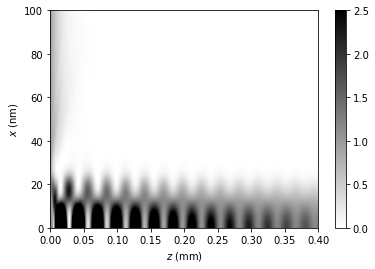

In [27]:
result = field.transpose()

fig, ax = plt.subplots()

im = ax.imshow(np.abs(result[:,:])**2, aspect='auto', cmap='gray_r', extent=[0, ztot, 0, xtot * 1e6])
ax.set_ylim(0, xtot * 1e6 )
im.set_clim(0, 2.5)
fig.colorbar(im)
ax.set_xlabel(r'$z$ (mm)')
ax.set_ylabel(r'$x$ (nm)')